In [273]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
import joblib

In [3]:
# read in "realistierter Stromverbrauch" 
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen", "Residuallast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop_duplicates(subset=["timestamp"], keep="first")
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"], mapping  = pd.factorize(df["item_id"])
mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

In [4]:
# mapping of item ids to time series
mapping

{0: 'Netzlast [MWh] Berechnete Auflösungen',
 1: 'Residuallast [MWh] Berechnete Auflösungen'}

In [5]:
df

,timestamp,item_id,target
0,2021-03-01 00:00:00,0,47857.25
1,2021-03-01 01:00:00,0,46619.25
2,2021-03-01 02:00:00,0,46391.50
3,2021-03-01 03:00:00,0,46883.50
4,2021-03-01 04:00:00,0,48725.75
...,...,...,...
71363,2025-03-26 19:00:00,1,NaN
71364,2025-03-26 20:00:00,1,NaN
71365,2025-03-26 21:00:00,1,NaN
71366,2025-03-26 22:00:00,1,NaN


In [ ]:
# alternatively could also read in Großhandelspreise from 2015-2025
# df_1 = pd.read_csv("data/Gro_handelspreise_201501010000_202101010000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
# df_2 = pd.read_csv("data/Gro_handelspreise_202001010000_202504060000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
# df = pd.concat([df_1, df_2])
# df = df.rename(columns={"Datum von":"timestamp"})
# df = df.drop(columns="Datum bis")
# df = df.drop_duplicates(subset=["timestamp"], keep="first")
# # unpivot data frame
# df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# # encode item id
# df["item_id"], mapping  = pd.factorize(df["item_id"])
# mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

In [6]:
# create TimesSeriesDataFrame for convenience
data = TimeSeriesDataFrame(df)
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2023"))

# Predictions

### Chronos Bolt Zero Shot

In [277]:
from src.predictors.chronos import Chronos

In [278]:
chronos = Chronos(model_name="amazon/chronos-bolt-tiny",
                  device_map="mps",
                  lead_times=np.arange(1, 65),
                  freq=pd.Timedelta("1h"))

# get zero shot predictions on training dataset - used for postprocessing
predictions_train = chronos.predict(data=data_train,
                                    previous_context_data=None)

# get zero shot perdictions on test dataset
predictions_raw = chronos.predict(data=data_test,
                                  previous_context_data=data_train)


Predicting: 100%|██████████| 676/676 [00:27<00:00, 24.90it/s]


In [279]:
joblib.dump(predictions_raw, "data/predictions/predictions_raw.joblib")

['data/predictions/predictions_raw.joblib']

### Quantile Regression – Benchmark

- simple quantile regresssion with seasonal variables (only calculated based on time information)

In [285]:
from src.predictors.quantile_regression import QuantileRegression

In [ ]:
quantreq = QuantileRegression(quantiles = np.arange(0.1, 1, 0.1),
                              lead_times=np.arange(1, 65),
                              freq=pd.Timedelta("1h"))

quantreq.fit(data_train)
predictions_benchmark_qr = quantreq.predict(data_test)

  6%|▋         | 4/64 [00:33<08:31,  8.53s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 19%|█▉        | 12/64 [01:38<07:29,  8.65s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 48%|████▊     | 31/64 [04:23<04:28,  8.13s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 64/64 [00:07<00:00,  

In [301]:
joblib.dump(predictions_benchmark_qr, "data/predictions/predictions_benchmark_qr.joblib")

['data/predictions/predictions_benchmark_qr.joblib']

### Nearest Neigbour Approach - Benchmark
- Berechne empirische Quantile basierend auf den vergangenen Werten des gleichen Wochentags und der gleichen Stunde.

In [289]:
from src.predictors.nearest_neighbour import NNPredictor

In [290]:
nn_predictor = NNPredictor(quantiles = np.arange(0.1, 1, 0.1),
                           lead_times=np.arange(1, 65),
                           freq=pd.Timedelta("1h"))

nn_predictor.fit(data_train)
predictions_benchmark_nn = nn_predictor.predict(data_test)

100%|██████████| 39164/39164 [00:58<00:00, 668.46it/s]


In [291]:
joblib.dump(predictions_benchmark_nn, "data/predictions/predictions_benchmark_nn.joblib")

['data/predictions/predictions_benchmark_nn.joblib']

# Postprocessing

### Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [294]:
from src.postprocessors.mle import PostprocessorMLE

In [295]:
postprocessor_mle = PostprocessorMLE()
postprocessor_mle.fit(data=predictions_train)
predictions_post_nrml = postprocessor_mle.postprocess(data=predictions_raw)

100%|██████████| 64/64 [00:01<00:00, 43.79it/s]


In [298]:
joblib.dump(predictions_post_nrml, "data/predictions/predictions_post_nrml.joblib")

['data/predictions/predictions_post_nrml.joblib']

### Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.



In [296]:
from src.postprocessors.qr import PostprocessorQR

In [297]:
postprocessor_qr = PostprocessorQR()
postprocessor_qr.fit(data=predictions_train)
predictions_post_qr = postprocessor_qr.postprocess(data=predictions_raw)

100%|██████████| 64/64 [00:03<00:00, 19.59it/s]


In [299]:
joblib.dump(predictions_post_qr, "data/predictions/predictions_post_qr.joblib")

['data/predictions/predictions_post_qr.joblib']

# Evaluation

In [302]:
from src.core.timeseries import get_quantile_scores, get_empirical_coverage_rates

In [ ]:
predictions_raw = joblib.load("data/predictions/predictions_raw.joblib")
predictions_post_qr = joblib.load("data/predictions/predictions_post_qr.joblib")
predictions_post_nrml = joblib.load("data/predictions/predictions_post_nrml.joblib")
predictions_benchmark_nn = joblib.load("data/predictions/predictions_benchmark_nn.joblib")
predictions_benchmark_qr = joblib.load("data/predictions/predictions_benchmark_qr.joblib")

In [303]:
all_predictions = {"chronos bolt tiny zero shot": predictions_raw, 
                   "postprocessed (QR)": predictions_post_qr,
                   "postprocessed (MLE)": predictions_post_nrml,
                   "benchmark (NN)": predictions_benchmark_nn,
                   "benchmark (QR)": predictions_benchmark_qr}

In [304]:
get_quantile_scores(all_predictions)

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,1165.07,1134.60,1151.46,1573.64,1945.51
0.2,1779.49,1758.05,1773.25,2427.13,3013.16
0.3,2160.19,2146.13,2155.12,3012.77,3676.65
0.4,2361.05,2350.22,2352.31,3357.32,4013.57
0.5,2404.28,2392.23,2390.16,3469.73,4063.59
0.6,2299.43,2283.53,2281.13,3369.84,3857.19
0.7,2042.51,2021.53,2024.79,3045.25,3389.15
0.8,1619.24,1593.31,1605.20,2465.55,2640.63
0.9,994.31,971.79,991.78,1566.64,1568.04


In [305]:
get_empirical_coverage_rates(all_predictions)

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,0.11,0.10,0.10,0.15,0.26
0.2,0.21,0.20,0.19,0.26,0.41
0.3,0.30,0.30,0.28,0.36,0.53
0.4,0.39,0.41,0.38,0.44,0.64
0.5,0.48,0.51,0.49,0.51,0.73
0.6,0.58,0.61,0.60,0.58,0.81
0.7,0.68,0.71,0.71,0.65,0.88
0.8,0.78,0.81,0.82,0.72,0.94
0.9,0.90,0.91,0.92,0.80,0.98


### Evaluation for individual model prediction (more details)

In [307]:
predictions_raw.get_crps(lead_times=[1, 12, 24, 32, 48, 64], mean=True)

{'Mean CRPS Score': 3436.78}

In [308]:
predictions_raw.get_quantile_scores(lead_times=[1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64,QS averaged over all lead times
quantile,,,,,,,
0.1,281.06,999.10,1165.42,1273.94,1318.51,1376.24,1069.05
0.2,417.00,1510.41,1755.92,1951.83,2026.06,2121.92,1630.52
0.3,504.72,1829.20,2120.95,2374.42,2467.57,2584.93,1980.30
0.4,554.18,2000.92,2321.34,2603.57,2694.53,2826.18,2166.79
0.5,570.34,2045.00,2375.78,2655.95,2735.84,2869.26,2208.70
0.6,555.01,1967.60,2285.49,2537.47,2605.72,2734.61,2114.32
0.7,507.44,1765.87,2041.51,2247.49,2301.64,2418.28,1880.37
0.8,420.07,1424.42,1629.40,1773.75,1808.86,1907.49,1494.00
0.9,282.92,902.00,1007.73,1076.28,1097.99,1162.08,921.50


In [309]:
predictions_raw.get_empirical_coverage_rates(lead_times=[1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64,Empirical coverage rates averaged over all lead times
quantile,,,,,,,
0.1,0.04,0.12,0.11,0.11,0.11,0.11,0.10
0.2,0.14,0.22,0.21,0.20,0.21,0.20,0.20
0.3,0.26,0.31,0.31,0.29,0.30,0.29,0.29
0.4,0.39,0.40,0.41,0.38,0.39,0.38,0.39
0.5,0.52,0.49,0.49,0.47,0.49,0.47,0.49
0.6,0.65,0.58,0.59,0.56,0.58,0.57,0.59
0.7,0.77,0.67,0.68,0.65,0.68,0.67,0.69
0.8,0.88,0.78,0.78,0.76,0.78,0.78,0.79
0.9,0.96,0.89,0.90,0.88,0.90,0.90,0.90


<Figure size 800x800 with 0 Axes>

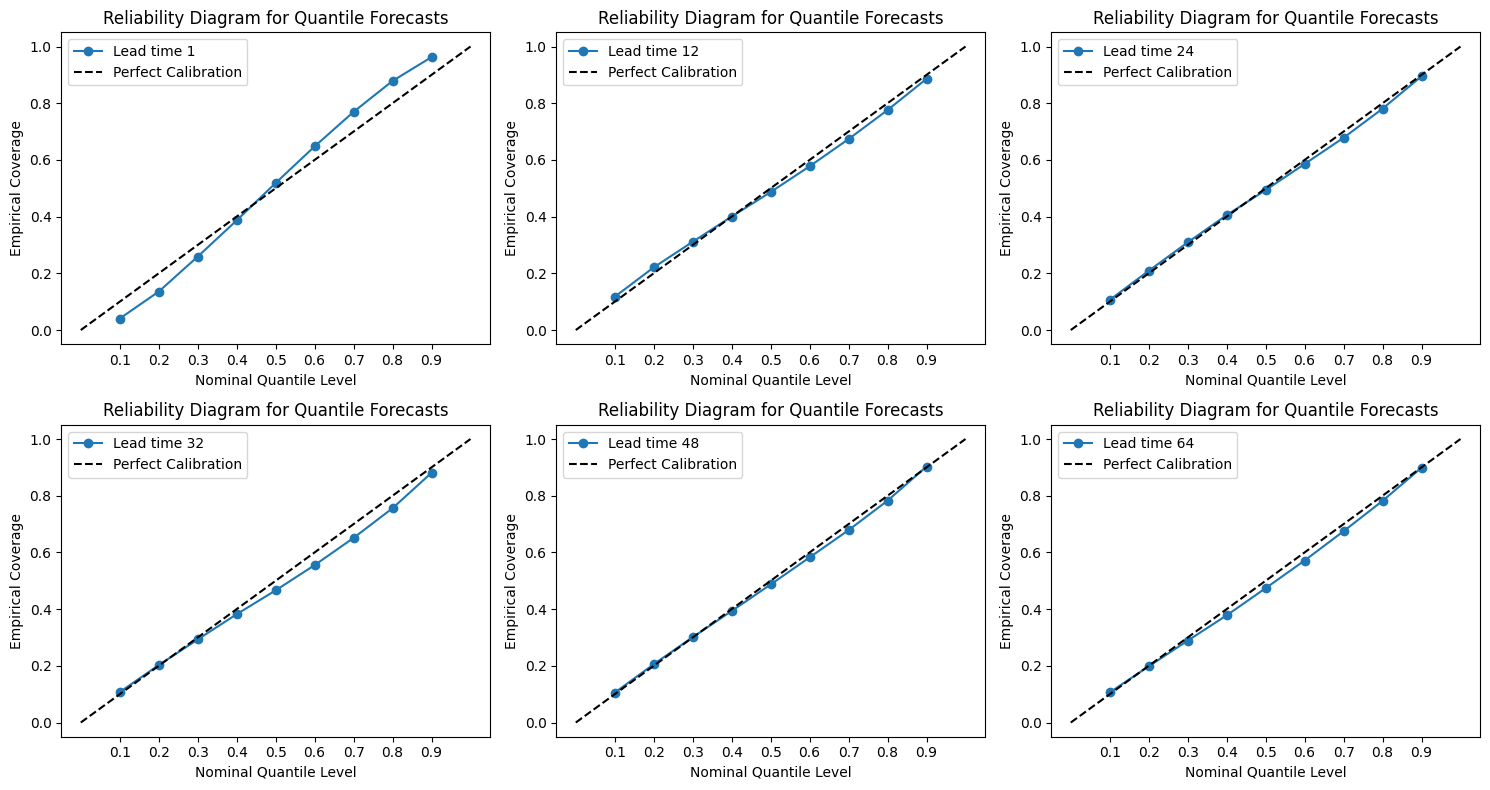

In [310]:
predictions_raw.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

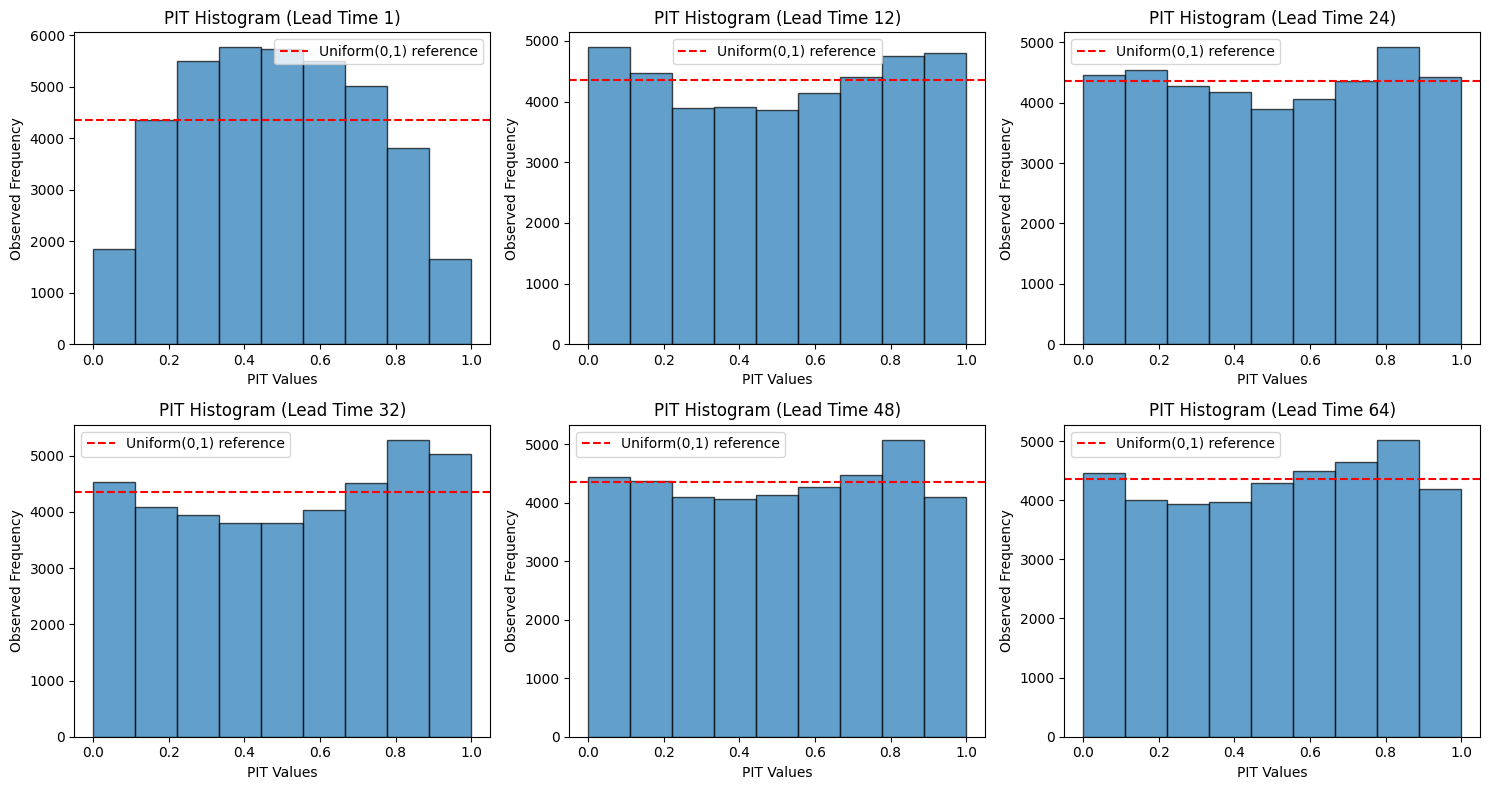

In [271]:
predictions_raw.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

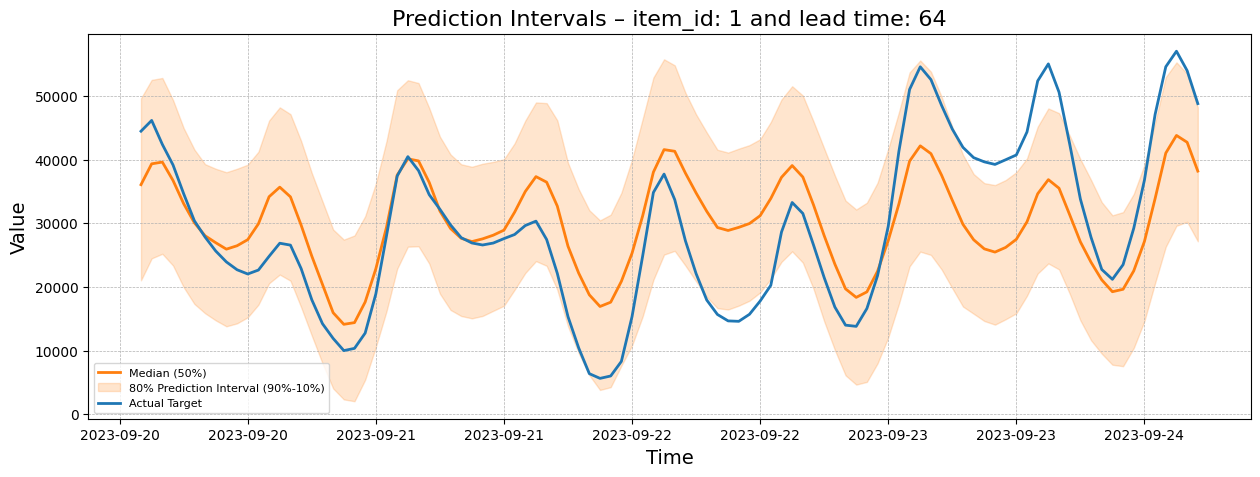

In [272]:
predictions_raw.results[64].get_random_plot(item_id=1)